<h1 style = "color:brown" align = "center"> Diabetes Analysis with K-Nearest Neighbors </h2>

![](https://i.imgur.com/nagCao6.jpeg)

Photo by Matt Chesin on Unsplash

# Concept Study

The following features have been provided to help us predict whether a person is diabetic or not:

* **Pregnancies:** Number of times pregnant.
* **Glucose:** Plasma glucose concentration over 2 hours in an oral glucose tolerance test. Less than 140 mg/dL is considered normal level of glucose.
* **BloodPressure:** Diastolic blood pressure (mm Hg). 120/80 is normal BP level for female above 18 yr old.
* **SkinThickness:** Triceps skinfold thickness (mm).
* **Insulin:** 2-Hour serum insulin (mu U/ml). 16-166 mIU/L is considered the normal level of insulin.
* **BMI:** Body mass index (weight in kg/(height in m)2).
* **DiabetesPedigreeFunction:** Diabetes pedigree function (a function which scores likelihood of diabetes based on family history).
* **Age:** Age (years).
* **Outcome:** Class variable (0 if non-diabetic, 1 if diabetic).

Data from: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database.

# Exploratory Data Analysis

## Libraries

In [8]:
# Necessary import
# for data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for model building and evaluation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')

## Diabetes dataset

A brief overview :

In [12]:
# read the data
db = pd.read_csv('diabetes.csv')
db.head() # first five rows

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Let's get more information about it :

In [15]:
db.info() # dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Our data set has 768 observations and 9 parameters. We seem to have no missing values and the variables are all integers or float. However we know that the outcome is just a set of binary values (1 for diabetic and 0 otherwise).

## Summary statistics

In [18]:
db.describe().T # data description

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Some features in our dataset have **zero values** which seems to be impossible. These values of zero (for `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` and `BMI`) do not make sense as there is some ranges for an alive human being which certainly do not include zero. Thus, they can be considered as not available or missing values.

In [20]:
# Replace 0 to NanN
db[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = db[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)

<p style="font-weight: bold;color:#FF4500"> Remark :</p> To simplify the process we have changed our outliers to NaN.

In [22]:
total = db[db.columns].isna().sum().sort_values(ascending = False) # check zero values
percent = round(100 * total / len(db), 2) # percentage over the whole dataset
nonsense_data = pd.concat([total, percent], axis = 1, keys = ['Total_NA', 'Raw_Data_%'])
nonsense_data

,Total_NA,Raw_Data_%
Insulin,374,48.70
SkinThickness,227,29.56
BloodPressure,35,4.56
BMI,11,1.43
Glucose,5,0.65
Pregnancies,0,0.00
DiabetesPedigreeFunction,0,0.00
Age,0,0.00
Outcome,0,0.00


Some variables (`Insulin` and `SkinThickness`) may be problematic as their proportions of missing values are too high for replacement.
Let's investigate to find out more about the variables in our dataset.

## Multicollinearity check

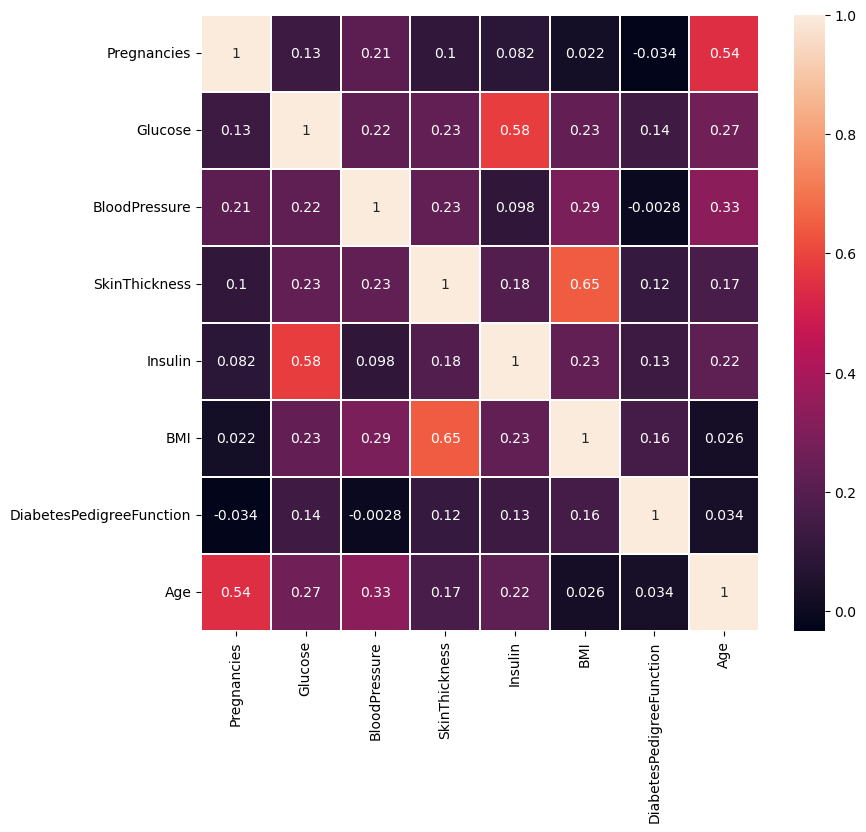

In [25]:
# Correlation map
plt.figure(figsize=(9,8))
sns.heatmap(db.drop(columns = "Outcome").corr(), annot=True, linewidths = .1);

There might be a risk of multicollinearity in our dataset. `Age` and `Pregnancies` are moderately correlated like `Insulin` and `Glucose`. Indeed, this is totally normal as in one hand, there is a minimal age for a woman to get pregnant and each pregnancy takes time, and in the other human bodies reaction to glucose is controlled by insulin.

Moreover, There is a strong positive correlation between `SkinThickness` and `BMI`. This is not surprising as both give information about the body mass.

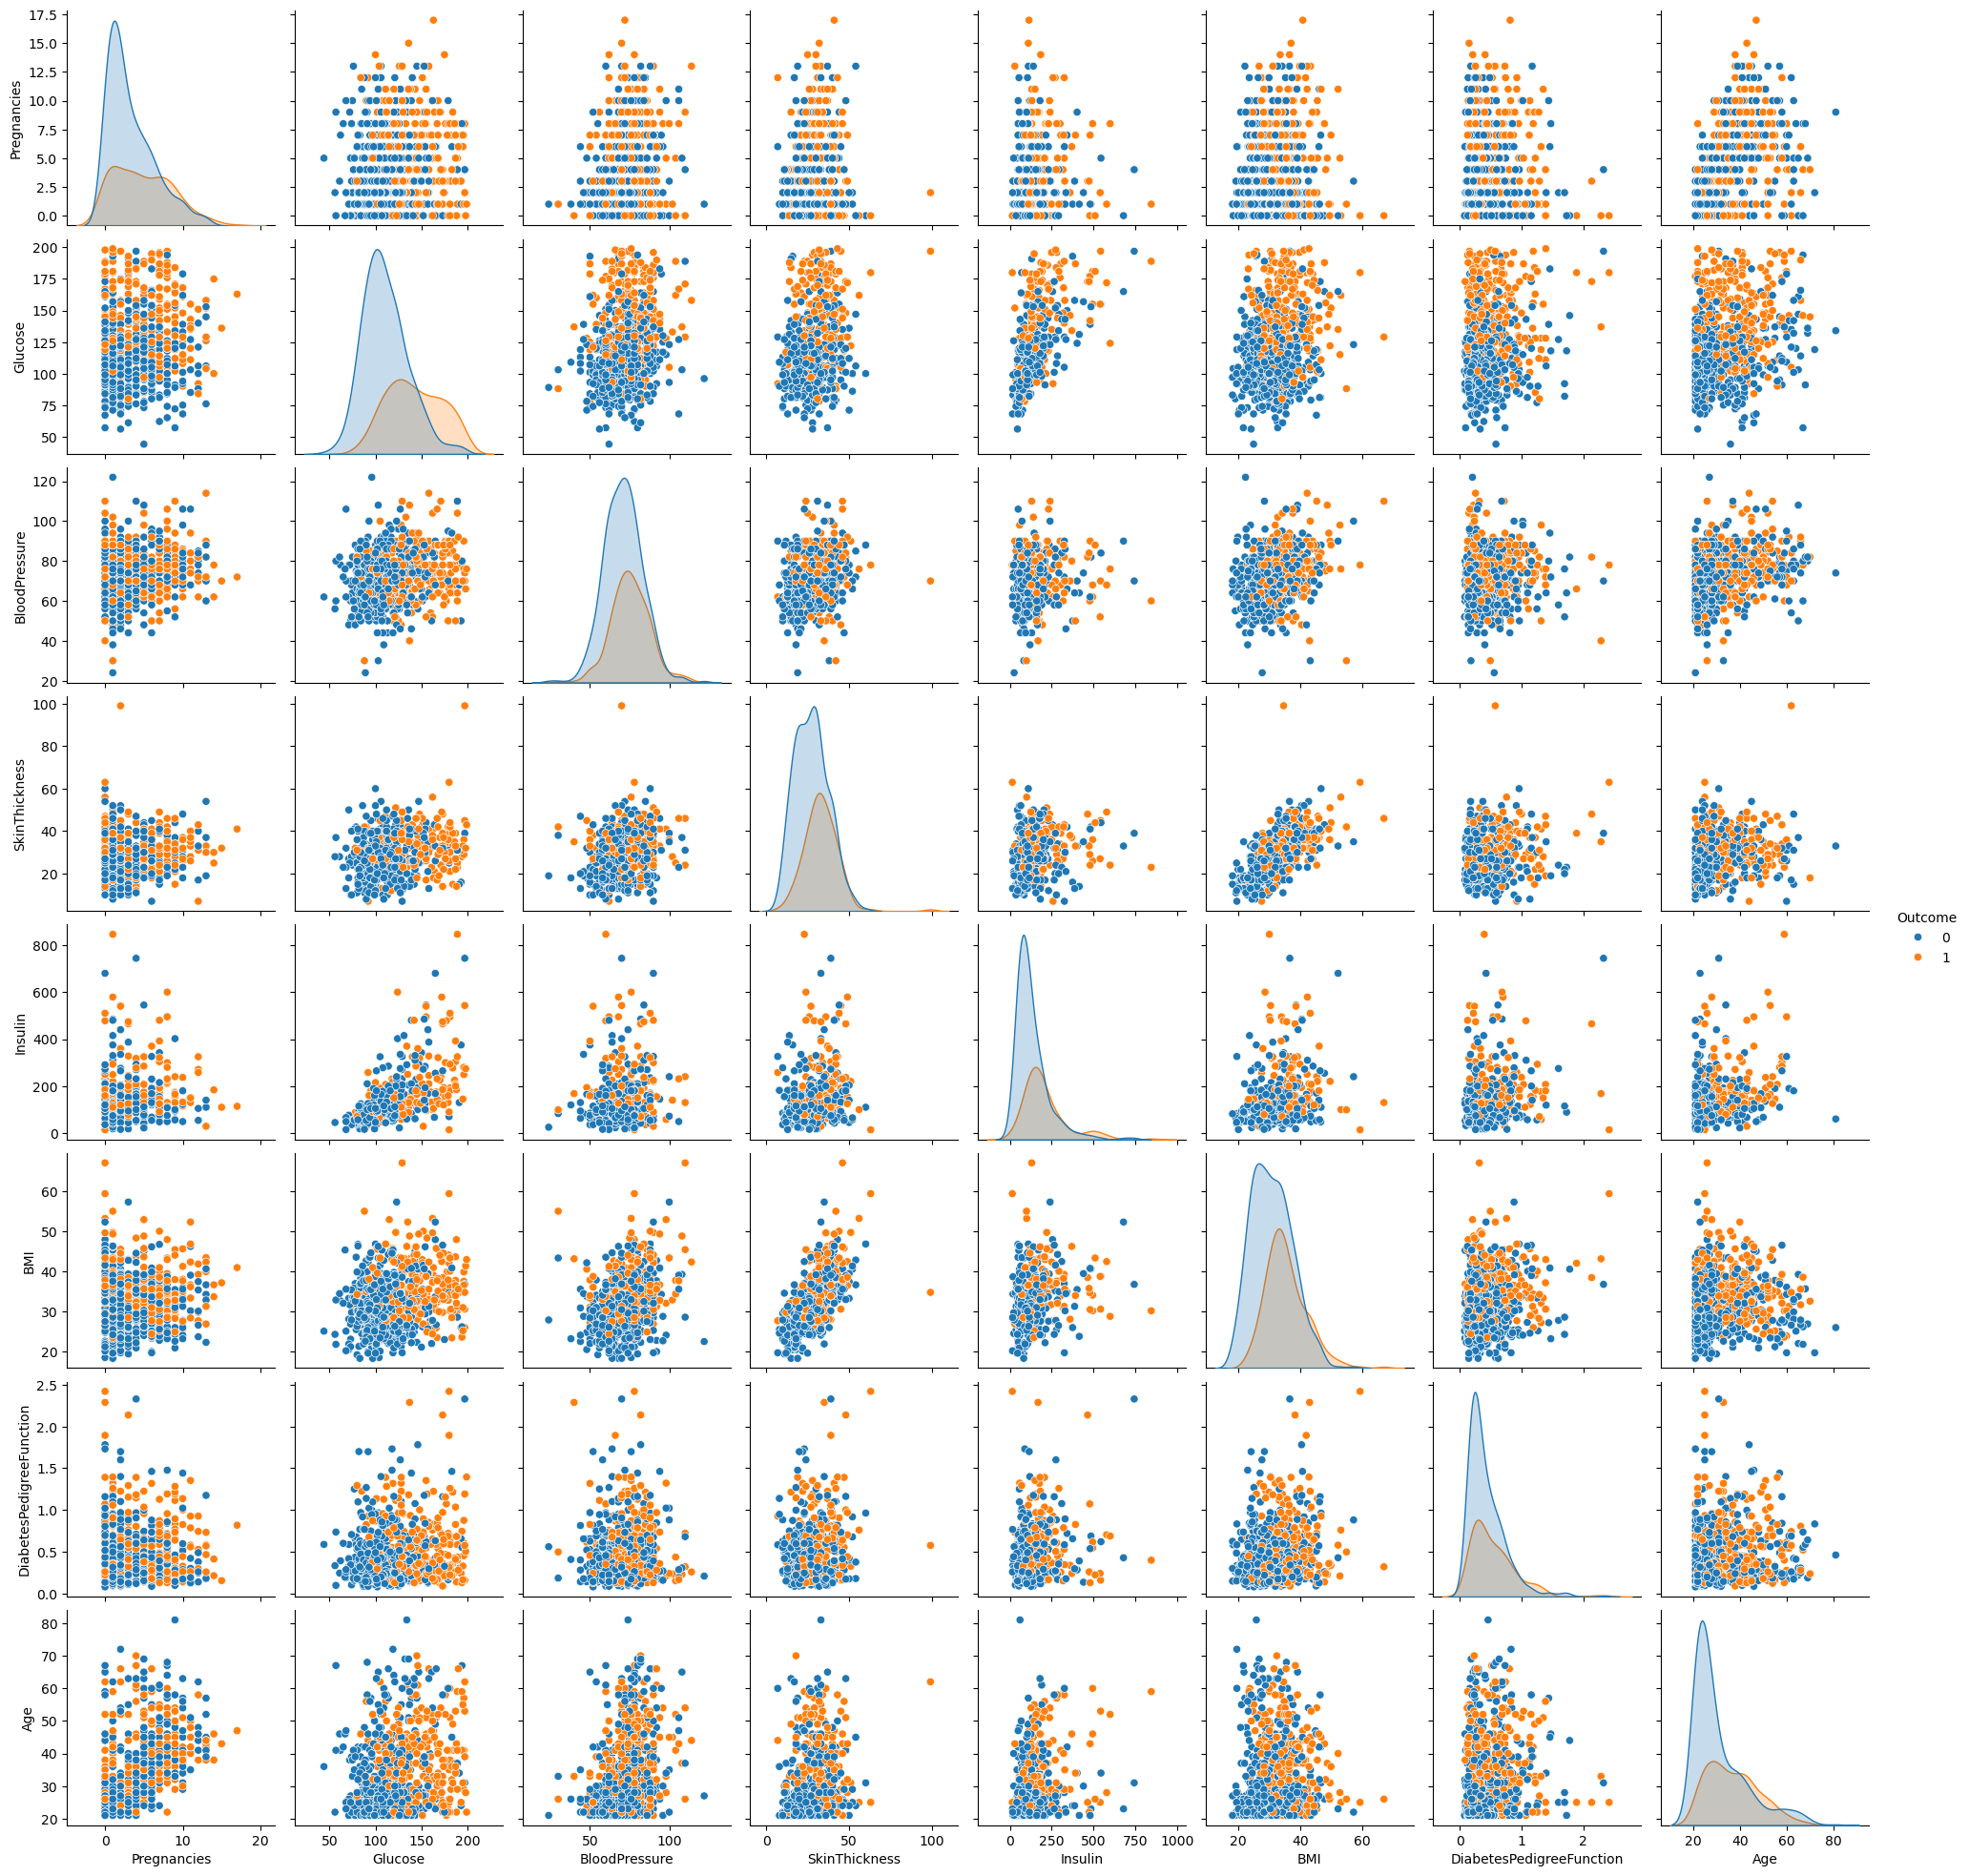

In [27]:
# Visualize relationships between each pair of variables
sns.pairplot(db, hue = "Outcome");

The relationships we should worry about are the ones between `SkinThickness` and `BMI`, and between `Insulin` and `Glucose`. In fact, this pairplot reveal that the pattern observed between `Age` and `Pregnancies` is not a real concern. Considering this, when selecting the feature variables for our models, we will ignore `SkinThickness` and `Insulin` which initially had more missing data.

## Handling missing values

For the parameters which have just few outliers, we are going to replace the problematics values by the median (as they are continuous, numerical). But for the Insulin and the SkinThickness, we'll delete the problematics observations because replacing them would bias the models we are going to train due to their size.

In [31]:
# replace missing values by median
db['Glucose'].fillna(db['Glucose'].median(), inplace = True)
db['BloodPressure'].fillna(db['BloodPressure'].median(), inplace = True)
db['BMI'].fillna(db['BMI'].median(), inplace = True)

# drop missing values
db.dropna(inplace = True) # as we realised reducing the data was more efficient

In [32]:
db.isna().sum() # check missing values

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

No missing values. That means the nonsense data have been removed.

Let's verify the summary statistics :

In [35]:
db.describe().T # summary statistics

,count,mean,std,min,25%,50%,75%,max
Pregnancies,394.0,3.286802,3.209635,0.000,1.00000,2.0000,5.000,17.00
Glucose,394.0,122.601523,30.784337,56.000,99.00000,119.0000,143.000,198.00
BloodPressure,394.0,70.654822,12.469919,24.000,62.00000,70.0000,78.000,110.00
SkinThickness,394.0,29.106599,10.504273,7.000,21.00000,29.0000,36.750,63.00
Insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.000,846.00
BMI,394.0,33.070558,7.015112,18.200,28.40000,33.2000,37.075,67.10
DiabetesPedigreeFunction,394.0,0.525543,0.350127,0.085,0.27025,0.4495,0.687,2.42
Age,394.0,30.814721,10.198971,21.000,23.00000,27.0000,36.000,81.00
Outcome,394.0,0.329949,0.470792,0.000,0.00000,0.0000,1.000,1.00


Everything has been fixed.

## Distribution of data

### Histograms

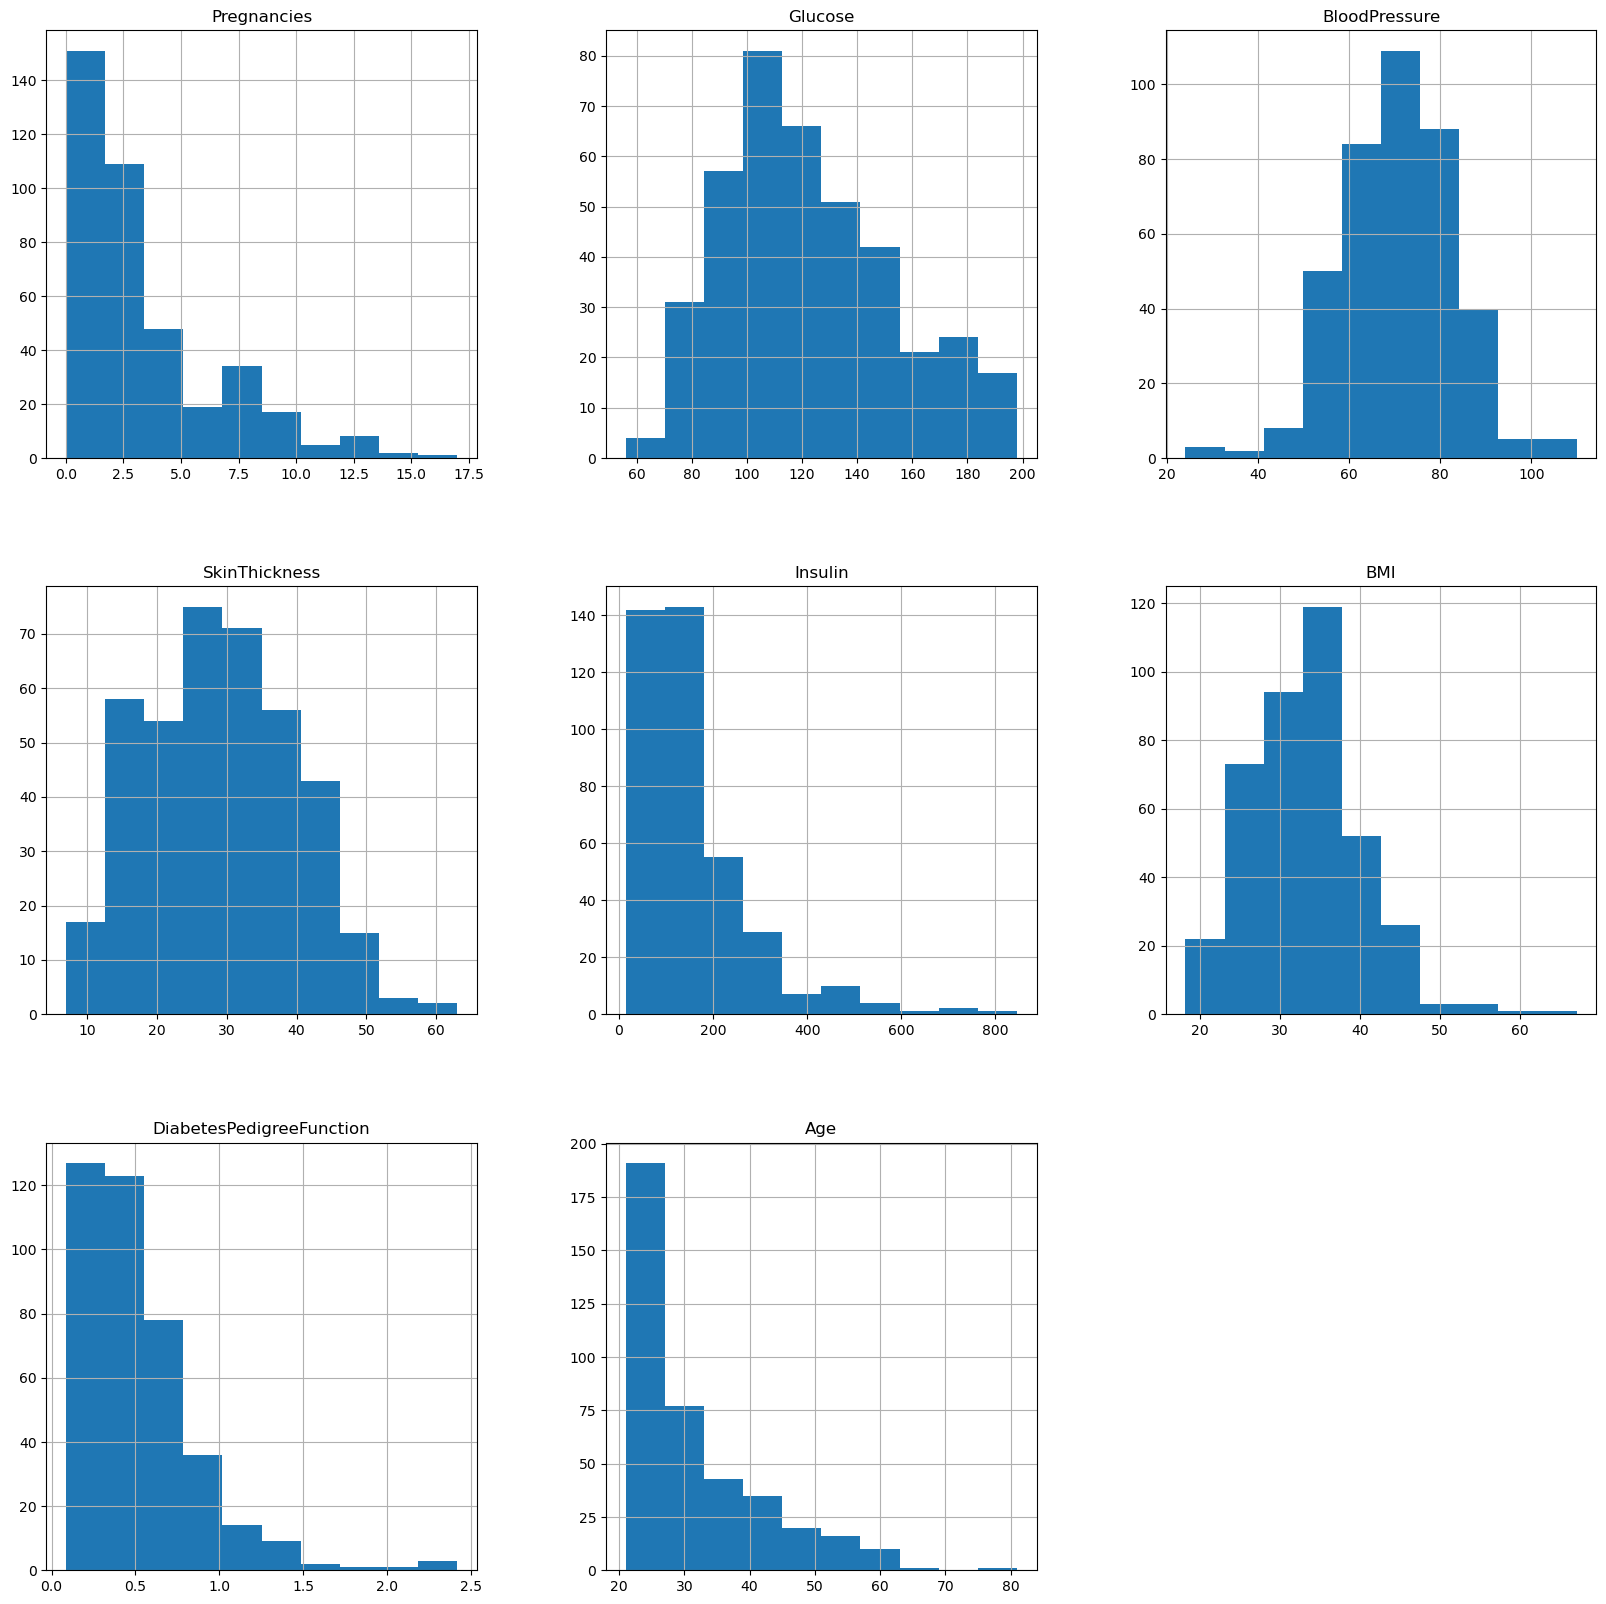

In [39]:
db[db.columns[:-1]].hist(figsize = (20,20)); # histograms of feature ariables

`Glucose`, `SkinThickness` & `BloodPressure` are almost normally distributed where as the other variables are skewed.

## Checking  balance of data

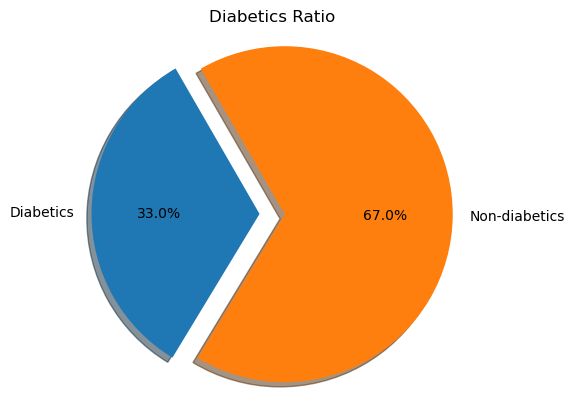

In [42]:
name = ['Diabetics','Non-diabetics'] # names labels
data = [db['Outcome'][db['Outcome']==1].shape[0],
        db['Outcome'][db['Outcome']==0].shape[0]] # outcome repartition
explode = (0.15, 0) # space between pies
plt.title('Diabetics Ratio') # title
plt.pie(data, explode = explode, labels = name , autopct = '%1.1f%%',
        startangle = 120, shadow = True) # pie chart
plt.axis('equal'); # title and plot on same axis

The dataset is biased towards non-diabetic patient: their number is almost twice the number of diabetic patients.

## Pregnancies and diabetics

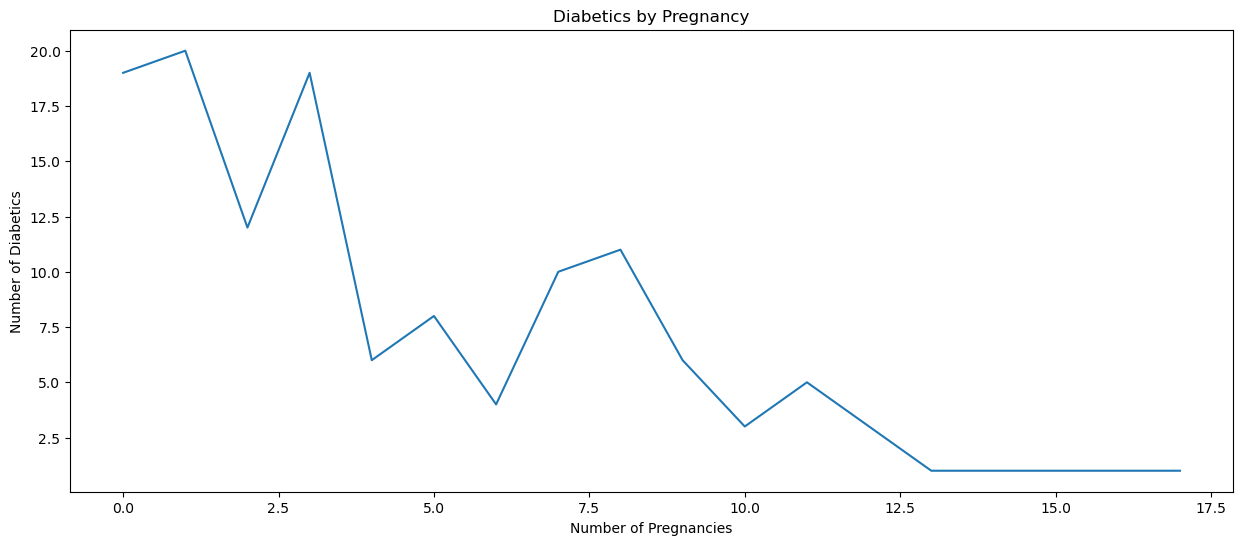

In [45]:
# Plot line of diabetics by pregnancies
fig, ax = plt.subplots(figsize = (15,6))
dbc = pd.DataFrame(db.groupby('Pregnancies')['Outcome'].sum())
dbc.plot(xlabel = 'Number of Pregnancies', ylabel = 'Number of Diabetics',
         ax = ax, title = 'Diabetics by Pregnancy', legend = False);

In our dataset, we have more diabetics with less pregnancies

## Insulin, Pedigree function and diabetes

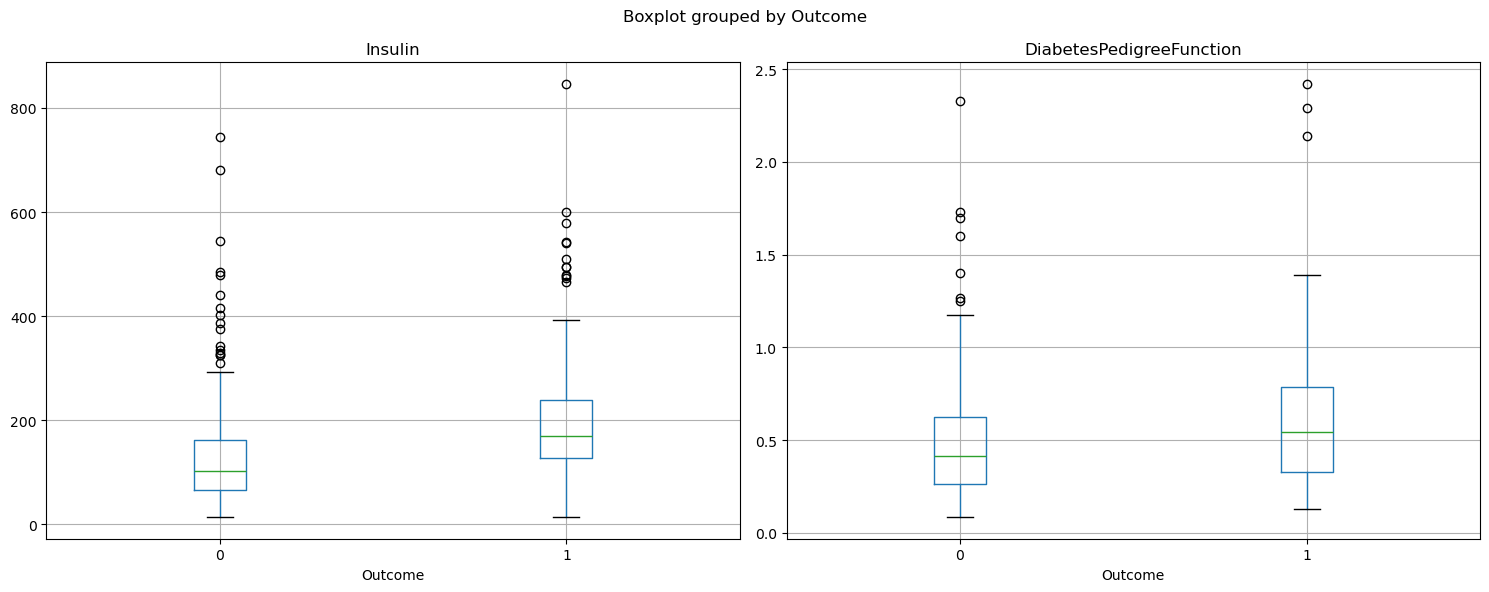

In [48]:
# Boxplots of Insulin and DiabetesPedigreeFunction by Outcome
fig, axes = plt.subplots(1, 2, figsize = (15,6))
db.boxplot(column = 'Insulin', by = 'Outcome', ax = axes.flatten()[0])
db.boxplot(column = 'DiabetesPedigreeFunction', by = 'Outcome', ax = axes.flatten()[1])
plt.tight_layout();

Diabetics tend to have a higher insulinemia. Besides that, the more the diabetes pedigree function is high the more the risk of having the disease is high.

## Blood sugar and diabetes

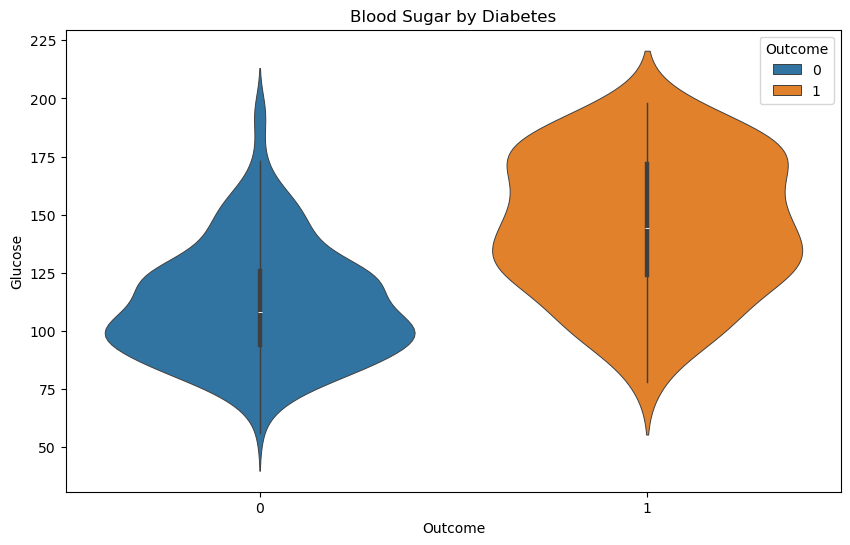

In [51]:
# Violinplot Blood Sugar by diabetes
plt.figure(figsize=(10,6))
sns.violinplot(data = db, x = "Outcome", y = "Glucose", hue = "Outcome", split = False, linewidth = 0.7)
plt.title('Blood Sugar by Diabetes');

The risk of the disease increase with blood sugar. We then have more cases of diabetes linked to hyperglycemia in our data set.

## BMI and Diabetes

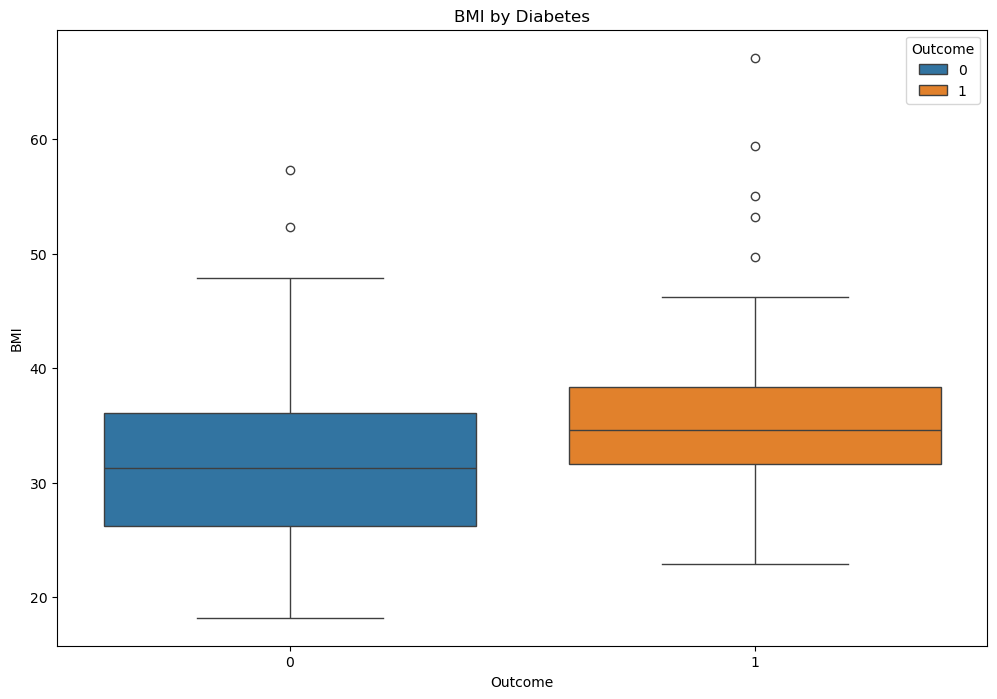

In [54]:
# Boxplot BMI by diabetes
plt.figure(figsize=(12,8))
sns.boxplot(data = db, x = 'Outcome', y = 'BMI', hue = "Outcome")
plt.title("BMI by Diabetes");

Even though, we have some outliers, we can see that the patients with a higher BMI tend more to be diabetics.

## Diabetes and Age

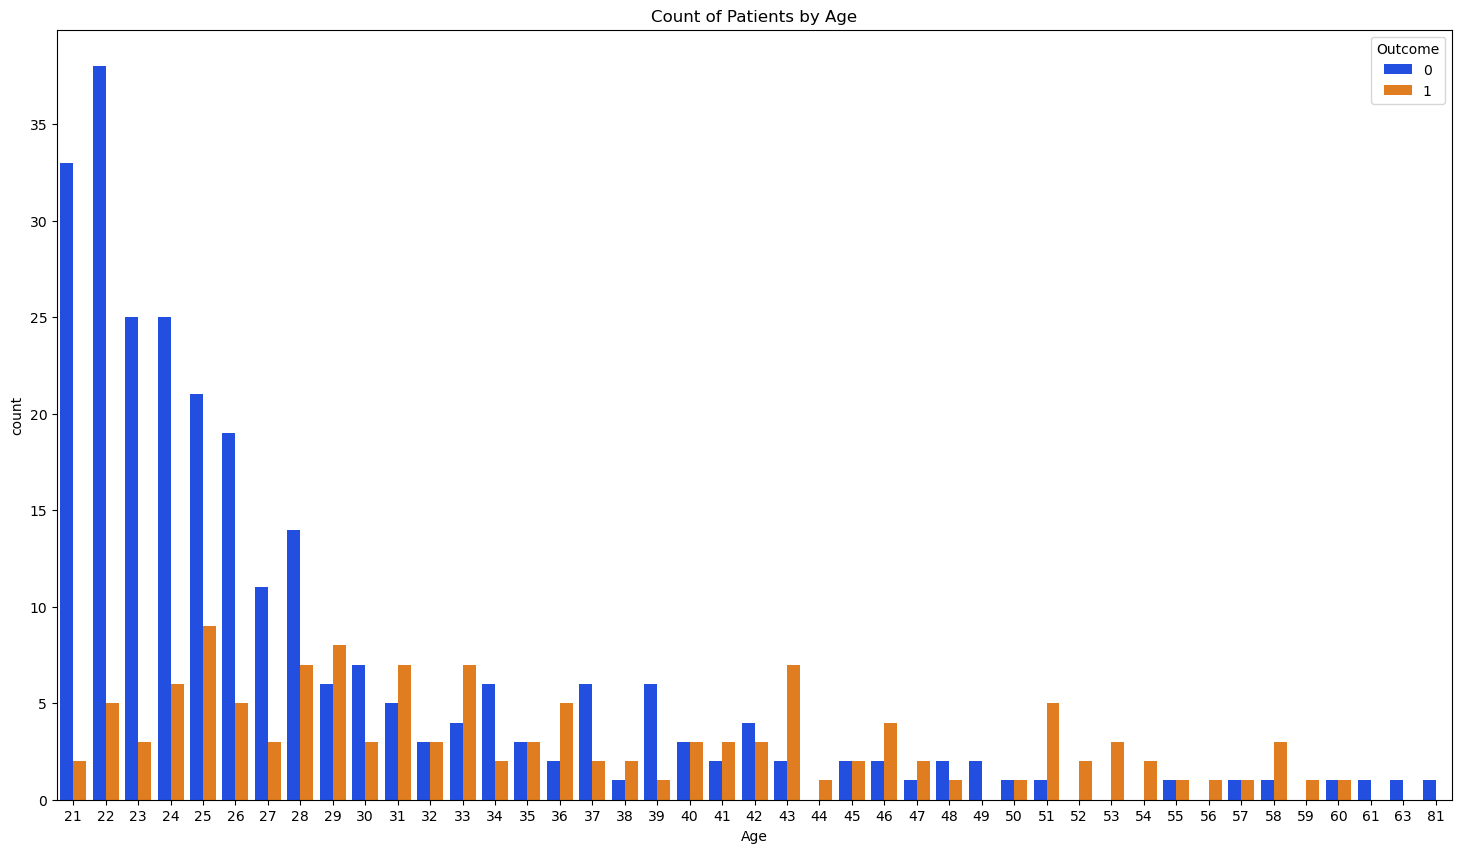

In [58]:
# Countplot of Diabets by Age
plt.figure(figsize = (18, 10))
sns.countplot(data = db, x = 'Age', hue = 'Outcome', palette = 'bright')
plt.title("Count of Patients by Age");

 We have the impression that most of the healthy patients in our dataset are young.

### DATA SPLITTING

We'll split the dataset in order to get 30 % for the test part and 70 % to train the models.

In [63]:
# target and features splitting
target = "Outcome"
X = db.drop(columns = [target, "SkinThickness", "Insulin"]) # removing target and multicollinearity
y = db[target]

# Train - Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Model building

The explanatory data analysis highlited the fact that we are trying to classify patients as diabetics or non-diabetics in function of their parameters. That is a binary classification with many features as Insulin, Glucose, Pregnancies... and one target value: Outcome. To do so, we will use KNN algorithm and compare it with Logistic regression model.

### KNN

One of the tricky part when implementing this algorithm is to decide of the number of neighbors : the value of K. For our work, we have decided to choose the **elbow method**. It will consist of creating a for loop that trains various KNN models with different k values, then keep track of the error_rate for each of these models with a list. At the end, we will simply choose the value of k for wich we have the most accurate model.

In [68]:
# The results we're going to check :
error_rate = []
test_scores = []
train_scores = []
accuracies = []

# The elbow method :
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    
    # Prediction, error rate and test accuracy calculation
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    test_acc = np.mean(pred_i == y_test)
    
    # Training and testing scores
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))
    accuracies.append(test_acc)

### A plot of the results :

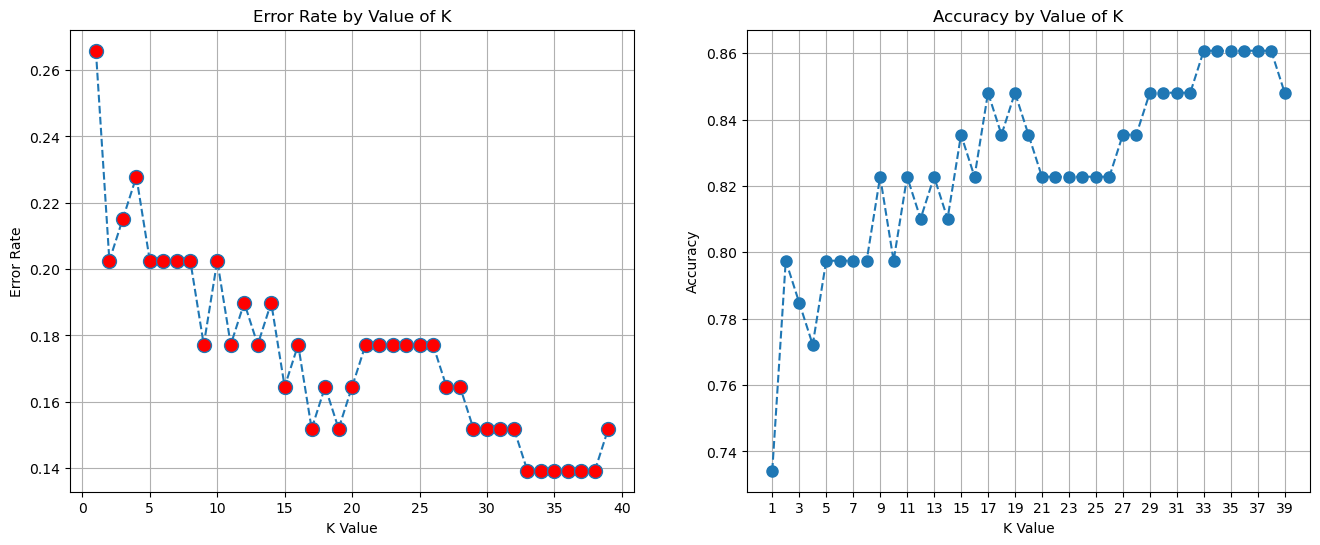

In [70]:
# Figure
plt.figure(figsize = (16,6))

# Plotting error rates for different values of K
plt.subplot(1, 2, 1)
plt.plot(range(1, 40), error_rate, linestyle = 'dashed', marker = 'o',
         markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate by Value of K')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.grid(True)

# Plotting accuracy scores for different values of K
plt.subplot(1, 2, 2)
plt.plot(range(1, 40), accuracies, marker = 'o', linestyle = 'dashed', markersize = 8)
plt.title('Accuracy by Value of K')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 40, step = 2))  # Adjust x-axis ticks if needed
plt.grid(True);

### Train vs Test Result Visualisation

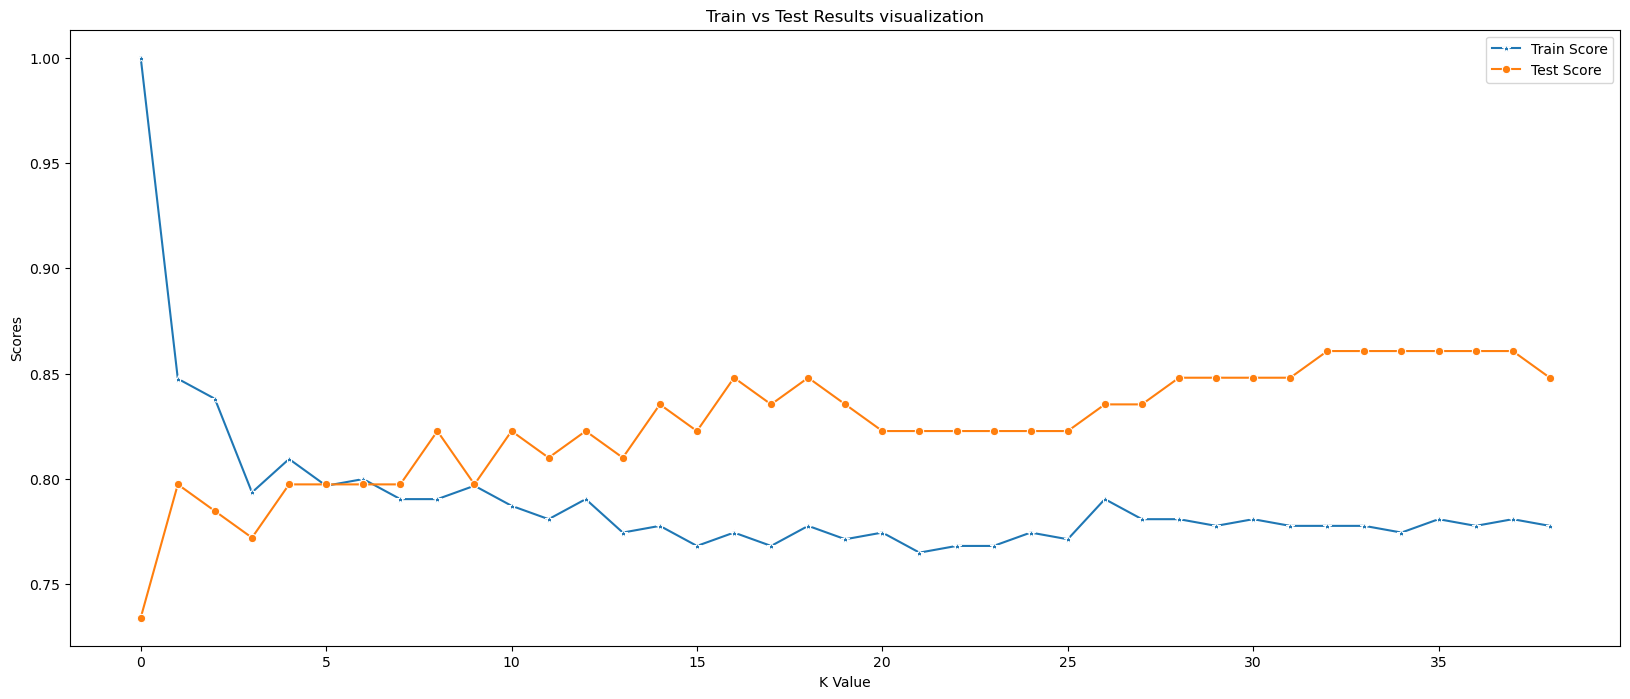

In [72]:
# Best K values train and test
plt.figure(figsize=(20,8))
sns.lineplot(train_scores, marker = '*', label = 'Train Score')
sns.lineplot(test_scores,  marker = 'o', label = 'Test Score')
plt.title("Train vs Test Results visualization")
plt.xlabel('K Value')
plt.ylabel('Scores');

In [73]:
# Get Best K for maximum score numerically
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('The maximum test score is {} % for the values of k = {}.'.format(
    round(max_test_score * 100, 2), list(map(lambda x: x+1, test_scores_ind))))

The maximum test score is 86.08 % for the values of k = [33, 34, 35, 36, 37, 38].


## KNN with optimal K  :

As we had many values of K with the same accuracies, we've chosen the smallest: K= 12.

In [76]:
# Model building
knn = KNeighborsClassifier(n_neighbors = 12)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=12)

In [77]:
# Predictions and results
pred = knn.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87        55
           1       0.80      0.50      0.62        24

    accuracy                           0.81        79
   macro avg       0.81      0.72      0.74        79
weighted avg       0.81      0.81      0.80        79



### Visualize confusion matrix

Accuracy: 81.01%


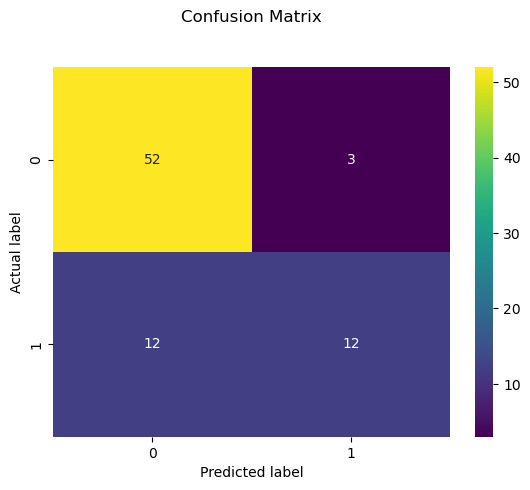

In [79]:
# Accuracy
KNNscore = accuracy_score(y_test, pred) 
print(f'Accuracy: {round(KNNscore * 100, 2)}%') 

# Confusion Matrix
cnf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "viridis" , fmt = 'g')
plt.title('Confusion Matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

### Logistic Model

We'll also train the logistic regression model in order to compare with KNN algorithm :

In [83]:
# Model building
LRclassifier = LogisticRegression(random_state = 0)
LRclassifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [84]:
# Predictions and results
y_pred = LRclassifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.90        55
           1       0.84      0.67      0.74        24

    accuracy                           0.86        79
   macro avg       0.85      0.81      0.82        79
weighted avg       0.86      0.86      0.86        79



Accuracy: 86.08%


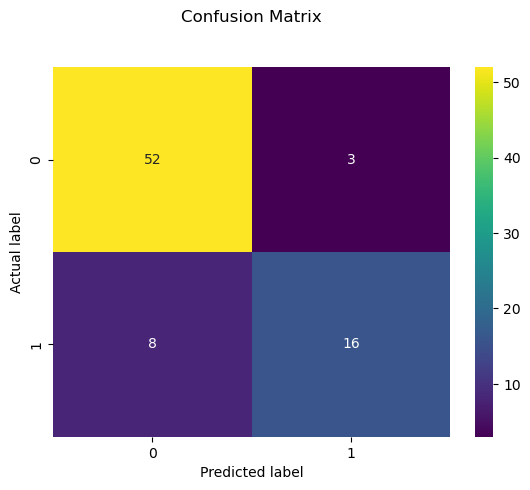

In [85]:
# Accuracy
score = accuracy_score(y_test, y_pred) 
print(f'Accuracy: {round(score * 100, 2)}%')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cm), annot = True, cmap = "viridis" , fmt = 'g')
plt.title('Confusion Matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

## ROC - AUC

Logistic regression: ROC AUC=0.806
KNN: ROC AUC=0.723


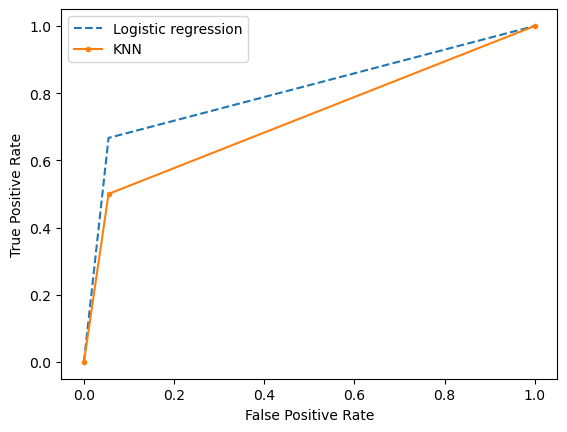

In [87]:
# Compute AUC scores
lr_auc = roc_auc_score(y_test, y_pred)
knn_auc = roc_auc_score(y_test, pred)

# Print scores
print('Logistic regression: ROC AUC=%.3f' % (lr_auc))
print('KNN: ROC AUC=%.3f' % (knn_auc))

# Calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
knn_fpr, knn_tpr, _ = roc_curve(y_test, pred)

# Plot roc curves
plt.plot(lr_fpr, lr_tpr, linestyle='--', label='Logistic regression')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')

# axis labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

# Oversampling

As we know that the data is imbalanced, let's do an oversampling :

In [91]:
# Instantiate SMOTE
smote = SMOTE(random_state = 37)

# Oversample the minority class in the training set
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

Let's visualize the result :

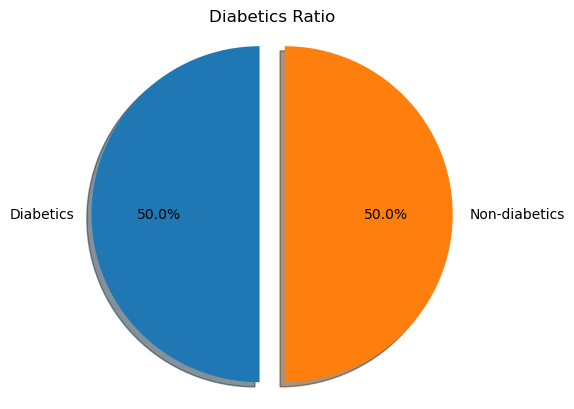

In [93]:
overy = y_train_oversampled # oversampled outcome
overdata = [overy[overy==1].shape[0], overy[overy==0].shape[0]] # outcome repartition
explode=(0.15, 0) # space between pies
plt.title('Diabetics Ratio') # title
plt.pie(overdata, explode = explode, labels = name , autopct='%1.1f%%',
        startangle = 90, shadow = True) # pie chart
plt.axis('equal'); # title and plot on same axis

The data set is now balanced. Let's train again our models and see the results.

## KNN after oversampling

In [96]:
# The results we're going to check :
overror_rate = []
ovtest_scores = []
ovtrain_scores = []
ovaccuracies = []

# The elbow method :
for i in range(1, 40):
    overknn = KNeighborsClassifier(n_neighbors = i)
    overknn.fit(X_train_oversampled, y_train_oversampled)
    
    # Prediction, error rate and test accuracy calculation
    overpred_i = overknn.predict(X_test)
    overror_rate.append(np.mean(overpred_i != y_test))
    overtest_acc = np.mean(overpred_i == y_test)
    
    # Training and testing scores
    ovtrain_scores.append(overknn.score(X_train_oversampled, y_train_oversampled))
    ovtest_scores.append(overknn.score(X_test, y_test))
    ovaccuracies.append(overtest_acc)

 ### A plot of the results

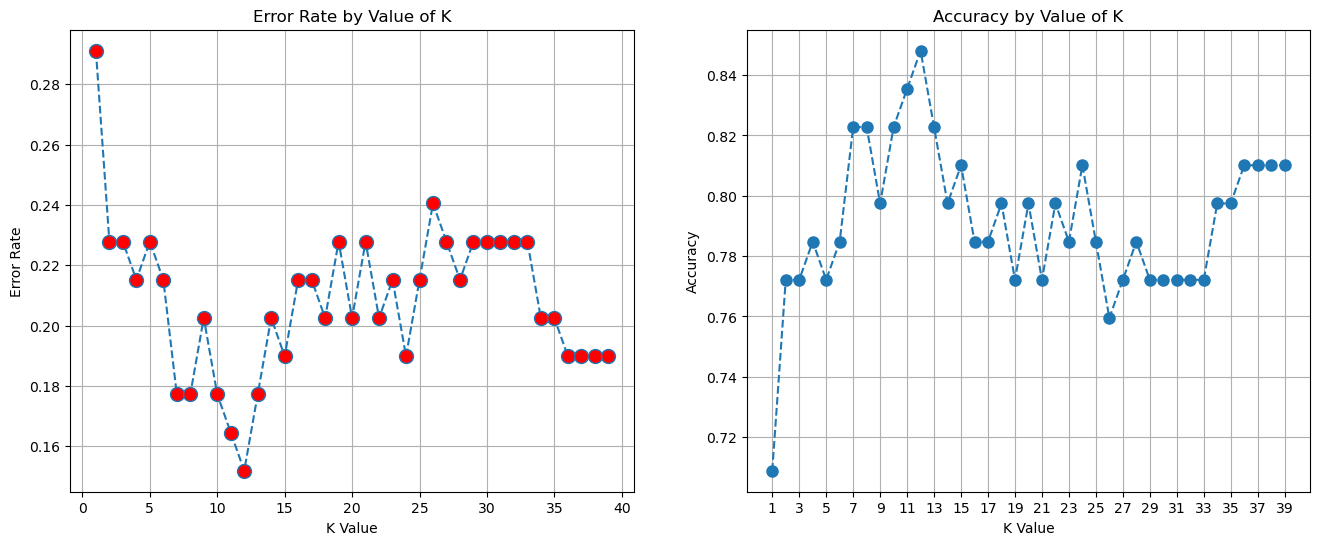

In [99]:
# Figure
plt.figure(figsize = (16,6))

# Plotting error rates for different values of K
plt.subplot(1, 2, 1)
plt.plot(range(1, 40), overror_rate, linestyle = 'dashed', marker = 'o',
         markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate by Value of K')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.grid(True)

# Plotting accuracy scores for different values of K
plt.subplot(1, 2, 2)
plt.plot(range(1, 40), ovaccuracies, marker = 'o', linestyle = 'dashed', markersize = 8)
plt.title('Accuracy by Value of K')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 40, step = 2))  # Adjust x-axis ticks if needed
plt.grid(True);

### Train vs Test results :

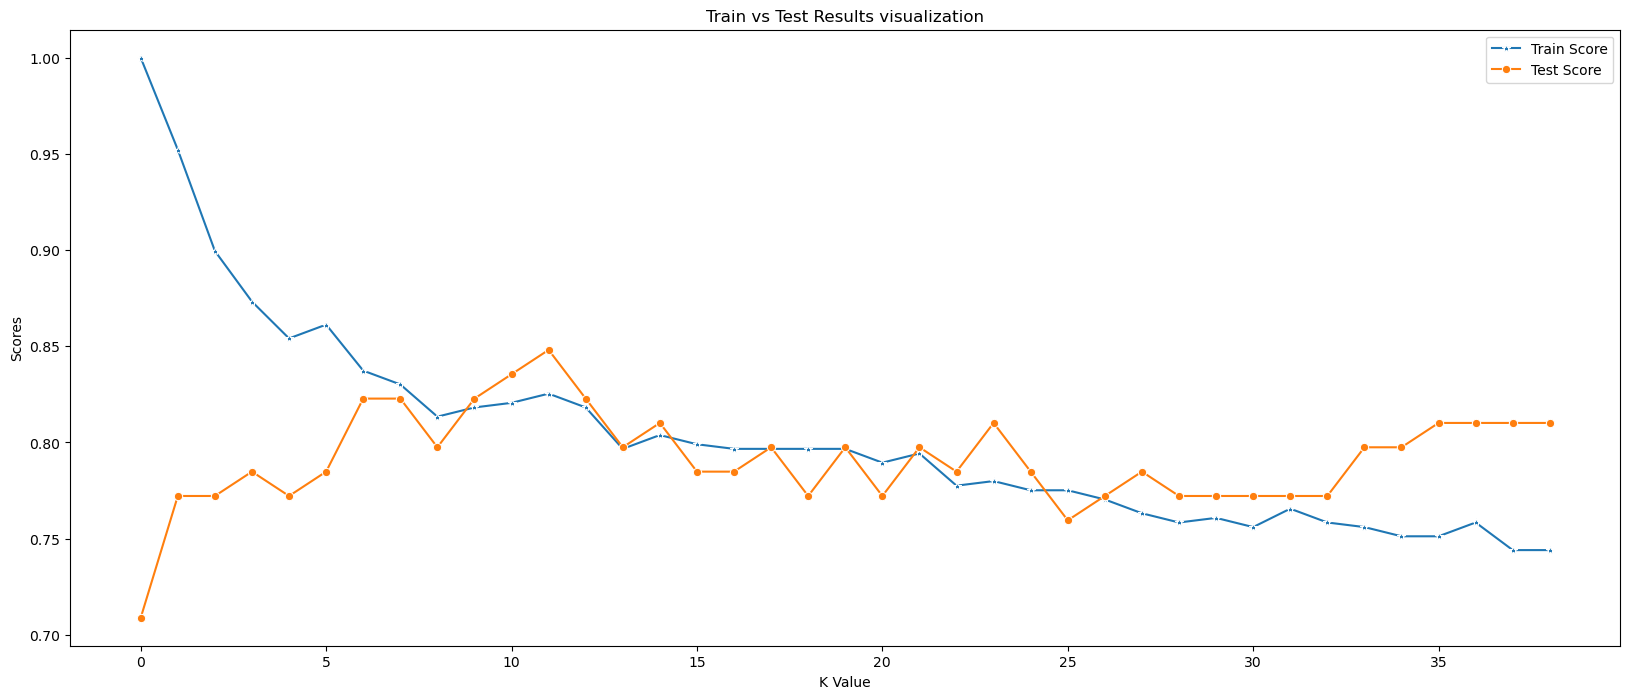

In [101]:
# Best K values train and test
plt.figure(figsize=(20, 8))
sns.lineplot(ovtrain_scores, marker = '*', label = 'Train Score')
sns.lineplot(ovtest_scores,  marker = 'o', label = 'Test Score')
plt.title("Train vs Test Results visualization")
plt.xlabel('K Value')
plt.ylabel('Scores');

In [102]:
# Get Best K for maximum score numerically
max_ovtest_score = max(ovtest_scores)
ovtest_scores_ind = [i for i, v in enumerate(ovtest_scores) if v == max_ovtest_score]
print('The maximum test score is {} % for the values of k = {}.'.format(
    round(max_ovtest_score * 100, 2), list(map(lambda x: x+1, ovtest_scores_ind))))

The maximum test score is 84.81 % for the values of k = [12].


## KNN classification report :

In [104]:
# Model Building
overknn = KNeighborsClassifier(n_neighbors = 12)
overknn.fit(X_train_oversampled, y_train_oversampled)

KNeighborsClassifier(n_neighbors=12)

In [105]:
# Model Predictions
ovpred = overknn.predict(X_test)
print(classification_report(y_test, ovpred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.88        55
           1       0.70      0.88      0.78        24

    accuracy                           0.85        79
   macro avg       0.82      0.86      0.83        79
weighted avg       0.87      0.85      0.85        79



Accuracy: 84.81%


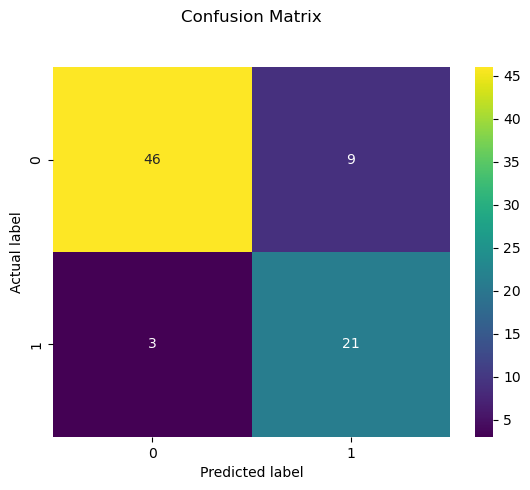

In [106]:
# Accuracy
score = accuracy_score(y_test, ovpred) 
print(f'Accuracy: {round(score * 100, 2)}%') 

# Confusion Matrix
cm = confusion_matrix(y_test, ovpred)
sns.heatmap(pd.DataFrame(cm), annot = True, cmap = "viridis" , fmt = 'g')
plt.title('Confusion Matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

### Logistic model after oversampling :

In [109]:
# Model Building
ovLRclassifier = LogisticRegression(random_state = 0)
ovLRclassifier.fit(X_train_oversampled, y_train_oversampled)

LogisticRegression(random_state=0)

In [110]:
# Model Predictions
overy_pred = ovLRclassifier.predict(X_test)
print(classification_report(y_test,overy_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        55
           1       0.71      0.71      0.71        24

    accuracy                           0.82        79
   macro avg       0.79      0.79      0.79        79
weighted avg       0.82      0.82      0.82        79



Accuracy: 82.28%


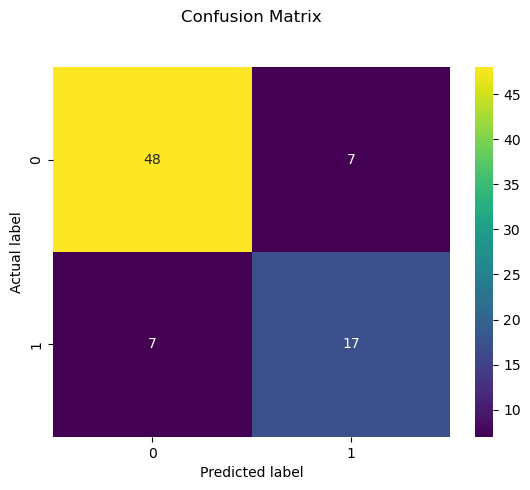

In [111]:
# Accuracy
overscore = accuracy_score(y_test, overy_pred) 
print(f'Accuracy: {round(overscore * 100, 2)}%')

# Confusion Matrix
overlrcm = confusion_matrix(y_test, overy_pred)
sns.heatmap(pd.DataFrame(overlrcm), annot = True, cmap = "viridis" , fmt = 'g')
plt.title('Confusion Matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

 ## ROC - AUC

Logistic regression: ROC AUC=0.791
KNN: ROC AUC=0.856


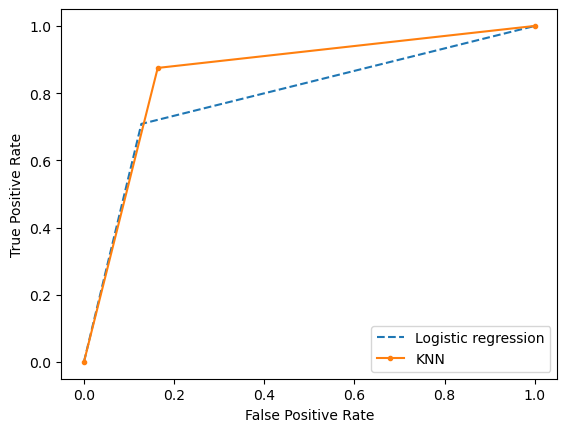

In [114]:
# Compute AUC scores
lr_auc = roc_auc_score(y_test, overy_pred)
knn_auc = roc_auc_score(y_test, ovpred)

# Print scores
print('Logistic regression: ROC AUC=%.3f' % (lr_auc))
print('KNN: ROC AUC=%.3f' % (knn_auc))

# Calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, overy_pred)
knn_fpr, knn_tpr, _ = roc_curve(y_test, ovpred)

# Plot roc curves
plt.plot(lr_fpr, lr_tpr, linestyle='--', label='Logistic regression')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')

# axis labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

## Results and conclusion

As a conclusion, the comparison of our KNN model with our Logistic regression one showed that, even though it's known as lazy (as its training phase only consists of storing training data), it can still performs well comparing to other models. In fact, after oversampling, its scores were better than the logistic regression ones. All this highlighted the importance of the methods used to clean the data and also the choice of the value of K, which can have a great impact.

---